# Rerun the model

Big thanks to this website for code: https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/

In [1]:
from transformers import pipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertConfig, TFAutoModelWithLMHead, TFAutoModel, AutoModel
from transformers import PreTrainedModel

from sklearn.model_selection import train_test_split

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

classifier = pipeline('sentiment-analysis')

import random
random.seed(42)

%matplotlib inline

In [2]:
save_directory = "distilbert-base-uncased"
config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False
transformer_model = TFAutoModel.from_pretrained(save_directory, from_pt=True, config = config)

input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 

embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(50, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(3, activation='sigmoid')(X)
tf.keras.layers.Softmax(axis=-1)
model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

for layer in model.layers[:3]:
    layer.trainable = False
    
model.compile(optimizer="Adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["acc"])

All PyTorch model weights were used when initializing TFDistilBertModel.

Some weights or buffers of the PyTorch model TFDistilBertModel were not initialized from the TF 2.0 model and are newly initialized: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
model.load_weights('models/final_models/route_only2/route_only2')

In [198]:
all_filenames = ["data/discussion_forum.csv", "data/review_forum.csv"]
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
combined_csv.to_csv("data/all_forums.csv", index=False, encoding='utf-8-sig')

# read in data
df = pd.read_csv('data/all_forums.csv')

In [199]:
# Rearrange the data so it is more like the training data
# This code taken from https://stackoverflow.com/questions/12680754/split-explode-pandas-dataframe-string-entry-to-separate-rows/54318064#54318064

def tidy_split(df, column, sep='|', keep=False):
    """
    Split the values of a column and expand so the new DataFrame has one split
    value per row. Filters rows where the column is missing.

    Params
    ------
    df : pandas.DataFrame
        dataframe with the column to split and expand
    column : str
        the column to split and expand
    sep : str
        the string used to split the column's values
    keep : bool
        whether to retain the presplit value as it's own row

    Returns
    -------
    pandas.DataFrame
        Returns a dataframe with the same columns as `df`.
    """
    indexes = list()
    new_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        if keep and len(values) > 1:
            indexes.append(i)
            new_values.append(presplit)
        for value in values:
            indexes.append(i)
            new_values.append(value)
    new_df = df.iloc[indexes, :].copy()
    new_df[column] = new_values
    return new_df

df = tidy_split(df, 'text', sep='. ')

In [200]:
print(len(df))
df.head(10)

594254


,topic,page_num,post_num,text,join_date,post_date,num_likes
0,Katabatic quilts and down shift,1,0,Have a hammock gear quilt right now,Jan 2012,Jul 5 2020,1
0,Katabatic quilts and down shift,1,0,I really like it but am annoyed with the cont...,Jan 2012,Jul 5 2020,1
0,Katabatic quilts and down shift,1,0,The down always seems to end up in the end of...,Jan 2012,Jul 5 2020,1
0,Katabatic quilts and down shift,1,0,I like the pad attachment system that Kataba...,Jan 2012,Jul 5 2020,1
1,Katabatic quilts and down shift,1,1,Do you roll or stuff the quilt when not in us...,Mar 2020,Jul 5 2020,0
1,Katabatic quilts and down shift,1,1,Gear with filled insulation like this should b...,Mar 2020,Jul 5 2020,0
1,Katabatic quilts and down shift,1,1,Best of luck with your hang~,Mar 2020,Jul 5 2020,0
2,Katabatic quilts and down shift,1,2,I stuff it and every night the down ends up a...,Jan 2012,Jul 6 2020,0
2,Katabatic quilts and down shift,1,2,It stays put if I spend 2 nights in the same p...,Jan 2012,Jul 6 2020,0
3,Katabatic quilts and down shift,1,3,I've had one of the Katabatic 20 degree quilt...,Jun 2016,Jul 6 2020,0


# Now label the dataset with labels from the model

### Get labels

In [51]:
# Create X values
tokenizer = AutoTokenizer.from_pretrained(save_directory)
X = tokenizer(
     list(df["text"]),
     padding=True,
     truncation=True,
     return_tensors="tf",
     max_length = 128
    )

In [54]:
preds = model.predict([X["input_ids"], X["attention_mask"]]) 

In [60]:
len(preds)

594254

### Now add the labels to the df

##### Start with the first 5000, then replace the first n rows of the df

For some reason, the merge works better this way. 

¯\\_(ツ)_/¯

In [201]:
# Add predicted labels to df
pred_labels = [np.argmax(preds[i], axis = 0) for i in range(len(preds))]
df_small = df.copy()

df_small = df_small[:5000] # remove in full set
df_small["pred_label"] = pred_labels[:5000] # add predicted labels
df_small["text"] = df_small["text"].str.strip().str.lower() # lower and strip whitespace

# remove empty rows
df_small['text'].replace('', np.nan, inplace=True)
df_small.dropna(subset=['text'], inplace=True)

#clean index mess
df_small.reset_index(inplace = True) 
df_small.drop(["index"], axis = 1, inplace = True)

print(len(df_small))
df_small.head()

4945


,topic,page_num,post_num,text,join_date,post_date,num_likes,pred_label
0,Katabatic quilts and down shift,1,0,have a hammock gear quilt right now,Jan 2012,Jul 5 2020,1,1
1,Katabatic quilts and down shift,1,0,i really like it but am annoyed with the conti...,Jan 2012,Jul 5 2020,1,0
2,Katabatic quilts and down shift,1,0,the down always seems to end up in the end of ...,Jan 2012,Jul 5 2020,1,0
3,Katabatic quilts and down shift,1,0,i like the pad attachment system that katabati...,Jan 2012,Jul 5 2020,1,2
4,Katabatic quilts and down shift,1,1,do you roll or stuff the quilt when not in use...,Mar 2020,Jul 5 2020,0,1


In [202]:
# Get labeled dataframe
labeled_df = pd.read_csv("data/labeled_forum_test.csv")
labeled_df["text"] = labeled_df["text"].str.strip().str.lower()

# Now merge
new_df = df_small.merge(labeled_df, how = 'left', on = "text")
print(len(new_df))
print(len(new_df)-len(df_small))
new_df.head()

5068
123


,topic,page_num,post_num,text,join_date,post_date,num_likes,pred_label,sentiment
0,Katabatic quilts and down shift,1,0,have a hammock gear quilt right now,Jan 2012,Jul 5 2020,1,1,1.0
1,Katabatic quilts and down shift,1,0,i really like it but am annoyed with the conti...,Jan 2012,Jul 5 2020,1,0,0.0
2,Katabatic quilts and down shift,1,0,the down always seems to end up in the end of ...,Jan 2012,Jul 5 2020,1,0,0.0
3,Katabatic quilts and down shift,1,0,i like the pad attachment system that katabati...,Jan 2012,Jul 5 2020,1,2,2.0
4,Katabatic quilts and down shift,1,1,do you roll or stuff the quilt when not in use...,Mar 2020,Jul 5 2020,0,1,1.0


### Now get the big dataframe and replace the first n rows. 

In [203]:
# Add predicted labels to df
pred_labels = [np.argmax(preds[i], axis = 0) for i in range(len(preds))]
full_df = df.copy()

full_df["pred_label"] = pred_labels # add predicted labels
full_df["text"] = full_df["text"].str.strip().str.lower() # lower and strip whitespace

# remove empty rows
full_df['text'].replace('', np.nan, inplace=True)
full_df.dropna(subset=['text'], inplace=True)

#clean index mess
full_df.reset_index(inplace = True) 
full_df.drop(["index"], axis = 1, inplace = True)

print(len(full_df))
full_df.head()

588736


,topic,page_num,post_num,text,join_date,post_date,num_likes,pred_label
0,Katabatic quilts and down shift,1,0,have a hammock gear quilt right now,Jan 2012,Jul 5 2020,1,1
1,Katabatic quilts and down shift,1,0,i really like it but am annoyed with the conti...,Jan 2012,Jul 5 2020,1,0
2,Katabatic quilts and down shift,1,0,the down always seems to end up in the end of ...,Jan 2012,Jul 5 2020,1,0
3,Katabatic quilts and down shift,1,0,i like the pad attachment system that katabati...,Jan 2012,Jul 5 2020,1,2
4,Katabatic quilts and down shift,1,1,do you roll or stuff the quilt when not in use...,Mar 2020,Jul 5 2020,0,1


### Combine the dataframes

In [204]:
# Combine df_small and full_df[len(new_df):]
df_full = new_df.append(full_df[len(new_df):])
df_full = df_full.rename(columns={"sentiment": "true_label"})
df_full.reset_index(inplace = True) 
df_full.drop(["index"], axis = 1, inplace = True)
df_full.head()

,topic,page_num,post_num,text,join_date,post_date,num_likes,pred_label,true_label
0,Katabatic quilts and down shift,1,0,have a hammock gear quilt right now,Jan 2012,Jul 5 2020,1,1,1.0
1,Katabatic quilts and down shift,1,0,i really like it but am annoyed with the conti...,Jan 2012,Jul 5 2020,1,0,0.0
2,Katabatic quilts and down shift,1,0,the down always seems to end up in the end of ...,Jan 2012,Jul 5 2020,1,0,0.0
3,Katabatic quilts and down shift,1,0,i like the pad attachment system that katabati...,Jan 2012,Jul 5 2020,1,2,2.0
4,Katabatic quilts and down shift,1,1,do you roll or stuff the quilt when not in use...,Mar 2020,Jul 5 2020,0,1,1.0


In [205]:
df_full.to_csv('data/full_forum_labeled.csv', index = False)

In [206]:
df = pd.read_csv('data/full_forum_labeled.csv')

# Analysis
Where did the model go wrong?

In [230]:
# See where predicted and true don't match
mismatch_df = df[df["true_label"].notnull()]
mismatch_df = mismatch_df[mismatch_df["pred_label"] != mismatch_df["true_label"]]

correct_df = df[df["true_label"].notnull()]
correct_df = correct_df[correct_df["pred_label"] == correct_df["true_label"]]

print("%s mismatches, %s correct." %(len(mismatch_df), len(correct_df)))

155 mismatches, 2795 correct.


## String lengths

In [208]:
string_lengths = [len(text) for text in mismatch_df["text"]]
print("Mismatched string lengths - Min: %s, Max: %s" %(min(string_lengths), max(string_lengths)))

all_string_lengths = [len(str(text)) for text in df["text"]]
print("All string lengths - Min: %s, Max: %s" %(min(all_string_lengths), max(all_string_lengths))) # max is 2595 ???

Mismatched string lengths - Min: 5, Max: 304
All string lengths - Min: 1, Max: 2595


In [209]:
sum(1 for x in all_string_lengths if x > 1000) # more than I expected...

41

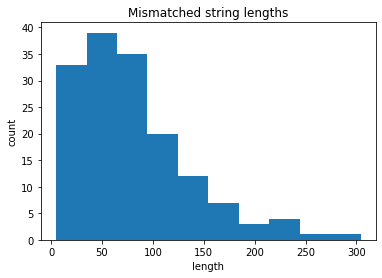

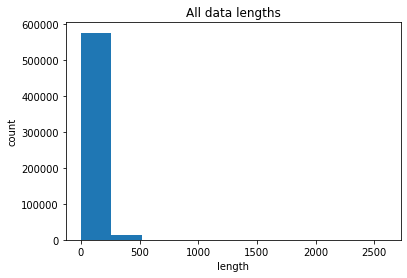

In [181]:
plt.hist(string_lengths)

plt.title("Mismatched string lengths")
plt.ylabel('count')
plt.xlabel('length')
plt.show()

plt.hist(all_string_lengths)

plt.title("All data lengths")
plt.ylabel('count')
plt.xlabel('length')
plt.show()

In [221]:
mask = (df['text'].str.len() >= 700)
df_large_strings = df.loc[mask]
len(df_large_strings)

187

In [227]:
for row in df_large_strings.index:
    label = df_large_strings["pred_label"][row]
    text = df_large_strings["text"][row]
    print("label: %s" %(label) + " text: %s" %(text))
    print("\n\n\n")
    
# These are all lists, troll posts, or long URLs. I'm deleting them. 
df = df[~mask]

label: 1 text: my normal personal gear for a few to many pitches of trad is: 3 lockers (one to clove hitch myself to the anchor~ two for guide mode on my belay device) 2 non-locking biners 2 double length slings (anchors) petzl reverso bail biner which holds: nut tool~ pirahna knife~ and a 5mm prusik cord chalk bag optional: food~ water~ phone~ extra layers (down jacket~ rain shell)~ roll of climbing tape (dual purpose for medical use and repairs)~ approach shoes optional x2: extra webbing if i expect i might bail and/or have unmaintained rappels i will cannibalize protection (slings~ biners~ etc) as needed to make an anchor if my two slings aren't ideal~ and also leave slings/gear behind in the event of a bail/emergency.




label: 1 text: for example: 1-do you were a helmet?  always?  sometimes?  how do you decide? 2-do you think helmets should offer protection principally from falling objects (rocks~ gear~ and so on)~ or do you think helmets should also provide impact protection? 3-

In [228]:
string_lengths = [len(text) for text in mismatch_df["text"]]
print("Mismatched string lengths - Min: %s, Max: %s" %(min(string_lengths), max(string_lengths)))

all_string_lengths = [len(str(text)) for text in df["text"]]
print("All string lengths - Min: %s, Max: %s" %(min(all_string_lengths), max(all_string_lengths))) # 

Mismatched string lengths - Min: 5, Max: 304
All string lengths - Min: 1, Max: 699


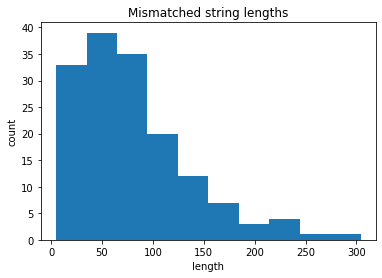

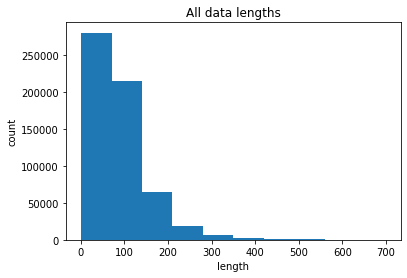

In [229]:
plt.hist(string_lengths)

plt.title("Mismatched string lengths")
plt.ylabel('count')
plt.xlabel('length')
plt.show()

plt.hist(all_string_lengths)

plt.title("All data lengths")
plt.ylabel('count')
plt.xlabel('length')
plt.show()

Now that the extra long strings are removed, the mismatched strings don't look abnormal in length.

## Word counting

Text(0, 0.5, 'frequency')

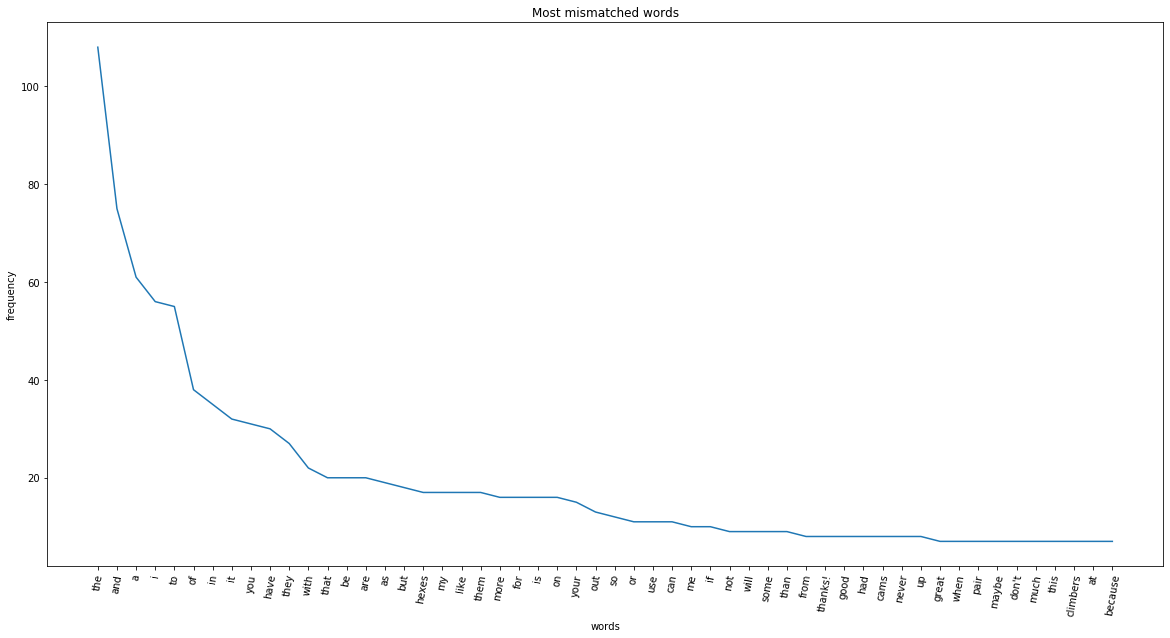

In [263]:
all_mismatch_words = mismatch_df.text.str.split(expand=True).stack().value_counts()
frequent_mismatch_words = pd.Series({k:v for (k,v) in all_mismatch_words.items() if v > 6})


plt.figure(figsize=(20,10))
plt.plot(frequent_mismatch_words)
plt.xticks(rotation=80)
plt.title("Most mismatched words")
plt.xlabel("words")
plt.ylabel("frequency")



This plot shows mostly stop words and common words, but two are particularly interesting: hexes and cams. It could be because they are controversial, or because they are just commonly talked about. Let's look at the correct graph. 

Text(0, 0.5, 'frequency')

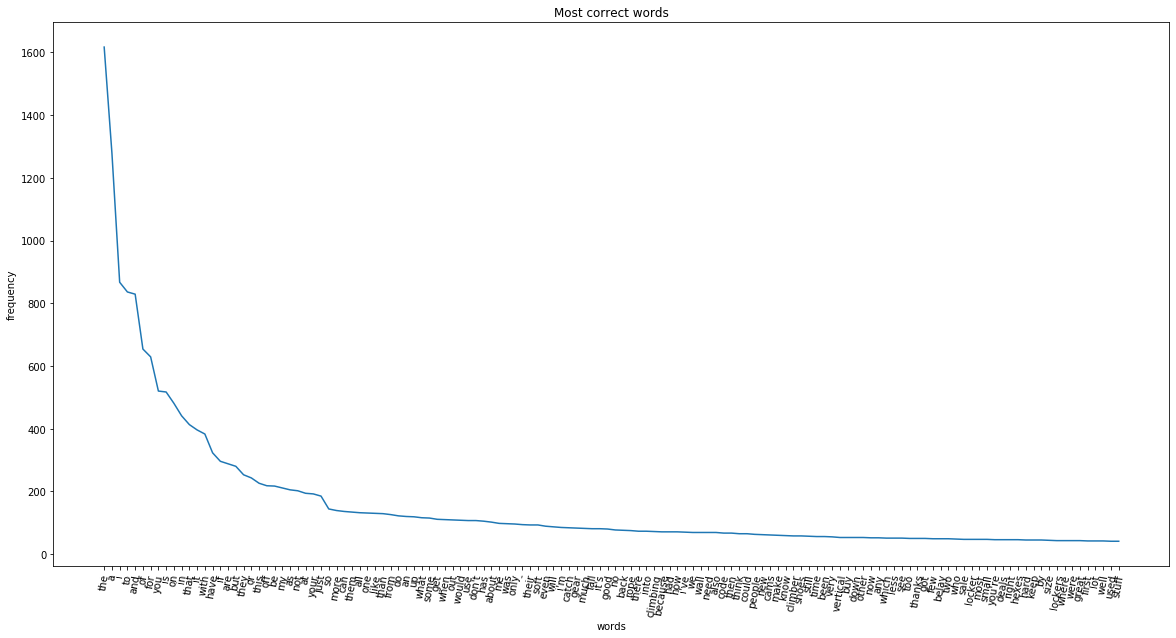

In [271]:
all_correct_words = correct_df.text.str.split(expand=True).stack().value_counts()
frequent_correct_words = pd.Series({k:v for (k,v) in all_correct_words.items() if v > 40}) # This had to be higher


plt.figure(figsize=(20,10))
plt.plot(frequent_correct_words)
plt.xticks(rotation=80)
plt.title("Most correct words")
plt.xlabel("words")
plt.ylabel("frequency")


This one had a lot more climbing specific words in it. Perhaps because that is what DistillBERT was trained on. Hexes and cams are much further down on the list. Let's look without stop words. 

Text(0, 0.5, 'frequency')

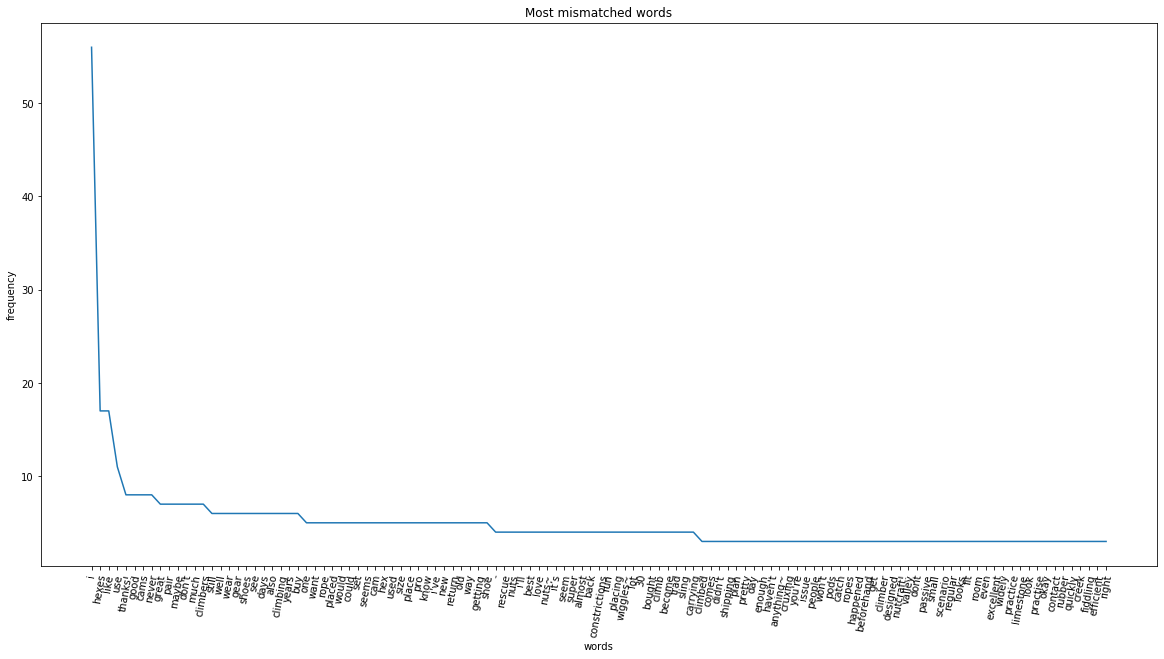

In [281]:
string = "me,my,myself,we,our,ours,ourselves,you,your,yours,yourself,yourselves,he,him,his,himself,she,her,hers,herself,it,its,itself,they,them,their,theirs,themselves,what,which,who,whom,this,that,these,those,am,is,are,was,were,be,been,being,have,has,had,having,do,does,did,doing,a,an,the,and,but,if,or,because,as,until,while,of,at,by,for,with,about,against,between,into,through,during,before,after,above,below,to,from,up,down,in,out,on,off,over,under,again,further,then,once,here,there,when,where,why,how,all,any,both,each,few,more,most,other,some,such,no,nor,not,only,own,same,so,than,too,very,s,t,can,will,just,don,should,now"
stop_list = string.split(",")

mismatch_words_dic = dict(mismatch_df.text.str.split(expand=True).stack().value_counts())
for key, value in list(mismatch_words_dic.items()):
    if key in stop_list or value in stop_list:
        del mismatch_words_dic[key]
        
        
frequent_mismatch_words = pd.Series({k:v for (k,v) in mismatch_words_dic.items() if v > 2})

plt.figure(figsize=(20,10))
plt.plot(frequent_mismatch_words)
plt.xticks(rotation=80)
plt.title("Most mismatched words")
plt.xlabel("words")
plt.ylabel("frequency")

Text(0, 0.5, 'frequency')

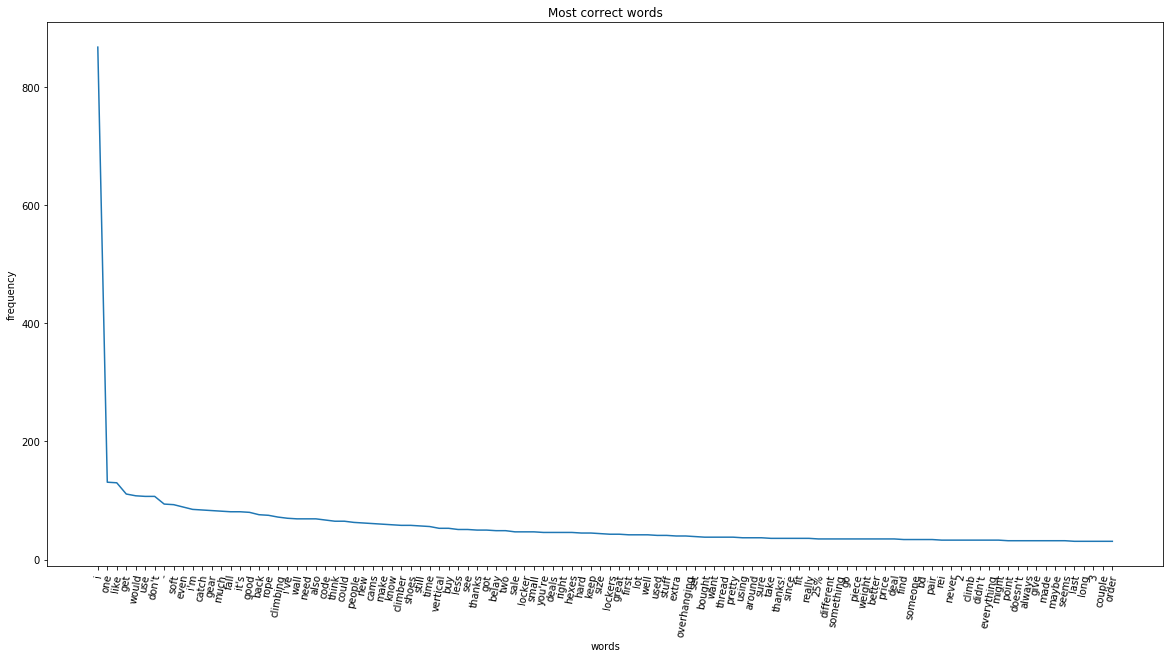

In [289]:
correct_words_dic = dict(correct_df.text.str.split(expand=True).stack().value_counts())
for key, value in list(correct_words_dic.items()):
    if key in stop_list or value in stop_list:
        del correct_words_dic[key]
        
        
frequent_correct_words = pd.Series({k:v for (k,v) in correct_words_dic.items() if v > 30})

plt.figure(figsize=(20,10))
plt.plot(frequent_correct_words)
plt.xticks(rotation=80)
plt.title("Most correct words")
plt.xlabel("words")
plt.ylabel("frequency")

Hexes appers near the top of the incorrect dataframe, and apperas in the lower one. Cams are often misclassified. 

In [314]:
hexes_df = df[df['text'].str.contains("hex").fillna(False)]
print(len(hexes_df))

cam_df = df[df['text'].str.contains(" cams | cams").fillna(False)]
print(len(cam_df))

2026
10098


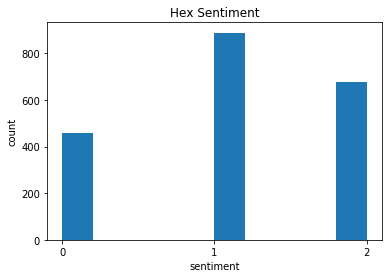

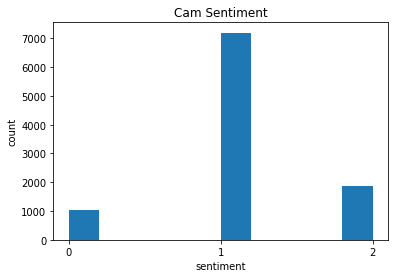

In [315]:
plt.hist(hexes_df["pred_label"])
plt.title("Hex Sentiment")
plt.xlabel("sentiment")
plt.ylabel("count")
plt.xticks([0,1,2])
plt.show()

plt.hist(cam_df["pred_label"])
plt.title("Cam Sentiment")
plt.xlabel("sentiment")
plt.ylabel("count")
plt.xticks([0,1,2])
plt.show()

In [316]:
for i in cam_df[:-10].index:
    print("label: %s text: %s" %(cam_df["pred_label"][i], cam_df["text"][i]))

label: 0 text: now i am going to say~ op making a gri gri like you mentioned with a soft catch feature would be extremely difficult because the grigri cams on the rope to stop it and there has to be so much force involved and then it is either an all or nothing cam
label: 1 text: has anyone come up with a way to replace these wires with something a bit more substantial?   i do recognize that these cams are as light as they are because they trimmed all the grams~ and the irony of thinking about doing anything to them that would increase weight
label: 1 text: for sport climbing multipitches i carry: the right amount of quickdraw reverso + 2 screwgates pas + screwgate prussik 2 x 1.20 meters slings each with 2 regular biners quicklink and a couple of random biners  climbing knife i don't do much pure trad climbing but for alpine climbing i add: no pas (i use the rope) no knife (leatherman crunch in the backpack) a few nuts full set of cams (or less depending on the route) switch the quick

label: 1 text: i will also extend this offer to other small cams  :)
label: 1 text: i can fit my entire rack (nuts~ tricams~ and a double rack of cams (size metolius 0 to 3" (bd 3)) on the forward loops and have the back two loops for slings & other miscellany
label: 1 text: some people daisy chain gear~ some put multiple cams per carabiner~ some use a gear sling in addition to the gear loops~ some will move the bigger bits of a standard rack to the rear loops carrying less alpines in favor rabbit runners..
label: 1 text: have you noticed both cams have also the same ce certification
label: 1 text: for those that have had experience with any size in the 1-6 range~ how do you like them so far?  how do they compare to totem basics~ master cams~ and regular totems? thanks!
label: 1 text: i wish totem made smaller cams.
label: 1 text: have you found you need to top stop more with these cams?
label: 2 text: you do lose ~2-3 inches~ but i really enjoy the regular and offset cams.
label: 1 te

label: 1 text: if it's indian creek you may well want quadruples in a certain size~ but if the area you're climbing in is more run of the mill a single rack of cams + nuts should be enough to get you safely up most single pitch stuff
label: 1 text: here's another one of mine: if the op ends up being serious about trad climbing (and i hope he does) it's inevitable he'll own a set of double cams within a year or so
label: 1 text: a second set of cams is not some obscure gear choice that some climbers prefer not to ever use
label: 1 text: every serious trad climber owns at least double set of cams and uses them often
label: 1 text: you see killer deals on full racks from time to time with everything you need to get started (spraying online about what cams are the best)
label: 1 text: here's another one of mine: if the op ends up being serious about trad climbing (and i hope he does) it's inevitable he'll own a set of double cams within a year or so
label: 1 text: a second set of cams is n

label: 1 text: and as the crack gets smaller~ small cams like tcus~ totem basics~ and aliens can do the job there~ making the smallest totem cam not as useful
label: 1 text: .75 size seems to be shallow or flaring and the other cams out there with their wide heads don't do as well as the green totem
label: 1 text: i think there are other cams that can work almost as as good in this size (green alien)
label: 2 text: these cams are awesome and top choice for placements in aid climbing for me
label: 2 text: awesome cams
label: 1 text: this time~ they replied instantly and told me to send the cams to their office in california~ which i did
label: 0 text: they never acknowledge receiving the cams and never updated me on the status of the warranty process
label: 1 text: 3 months after they received the cams)
label: 1 text: this time~ they replied instantly and finally told me that they would replace my cams with the new revolution~ which were supposed to be “stronger so you won’t have to dea

label: 0 text: this has to do with the end point in easy retraction of the cams when pulling the trigger
label: 0 text: by pulling the trigger it is too easy to retract cams into an overcammed position
label: 0 text: you could call it a "feel" issue~ but practically it comes down to stuck cams
label: 0 text: the basics are better finished and tiny bit smaller~ the original aliens (recalled cams aside) are a little inconsistent in manufacture but all place just fine
label: 0 text: i did not have the trouble others have with them with the end cap and cams coming off~ but based on the safety related problems fixe's non-chalance about it~ and poor customer service from fixe~ i boycott them
label: 2 text: tcus: jcm~ we are going to have to disagree here; in the real world placing small cams~ the tcus still offer some better placements than any of the 4 cam central stem units
label: 2 text: it makes no sense to me to have two sets of 4 cam small cams when the tcu offers so much comparative v

label: 0 text: the spring on the cams seemed really weak and the placement was in a flaring crack~ placed a sling on it and carefully moved passed it~ all i could think was that piece moving around in the flare
label: 0 text: these were my first cams~ and i liked them~ but i have run into some issues
label: 1 text: like others have said~ i find the springs to be on the weak side~ giving them a greater tendency to walk than other cams
label: 2 text: the lobe angles are steeper compared to other cams~ restricting their placement- especially in pockets and pods with a constricted opening
label: 1 text: overall these aren't bad cams~ and i still use mine from time to time~ but it may be better to invest in something a little more durable.
label: 1 text: and i have full racks of bd's~ aliens~ metolius tcu's and fcu's~ and various flex cams
label: 1 text: looks like a telescoping stick clip that can be used for cams and nuts~ and for threading the rope
label: 1 text: really just depends i su

label: 1 text: when i would get to my belays i would have all my cams
label: 1 text: 1) set of nuts   2) set of slung hexs   3) set of cams   4) tcu's 00-4 (c3's)   5) doubles of cams biger that #4 tcu   5) tri-cams in sizes that are usefull in your area   6) micro-nuts   7a) big gear (cams/big bros)   7b) small gear (ball nuts~ more micro-nuts)   7c) triples/more cams/tcus
label: 1 text: nuts first cams second
label: 2 text: it is very cool to have so many options for small cams!
label: 1 text: that is some pretty intense machine work huh?  these things are going to make dragon cams look cheap i bet.
label: 1 text: totem cams look like a unique product with some very interesting features
label: 1 text: that being said~ the next cams i purchase will be from wired bliss!
label: 2 text: they look cool but until there are real world cams for people to use then it's all meaningless anyway.
label: 1 text: looks like the cams will be available in august on the company's website  and they wil

label: 1 text: i'm guessing that these cams are from korea since the address is garden grove~ basically korea in  la
label: 1 text: that doesn't mean that they are bad cams
label: 1 text: the cams look like alien knock-offs~ complete with trigger sleeves!  can't tell if they ha e an internal spring or not.
label: 1 text: something tells me i would probably cry if i had to run it out on one of those cams~ danger will robinson!
label: 1 text: they don't have a very good range on the cams~ the gsc #6(1.25") has: 26.3mm/38.1mm   while a camelot .75 has: 23.9-41.2 mm    that and it seems the site should be on engrish.com   "cams should be store dry"
label: 1 text: perhaps "golden spiral" refers to the gleam of your shinny new rack reflecting in the sun as you plummet after one of their cams fail?
label: 1 text: i hav fur rack of this cams
label: 1 text: while trying to figure out how to place my cams better i found different recommendations from different manufacturers:    black diamond: "i

Looking through these, it appears that the model gets confused when the sentence discusses multiple items.

In [37]:
# Create X values
confusing_sentences = ["ii i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i ",
                      "25% off for a set of the best cams: Black Diamond",
                      "The repulican party does not support our use of public land",
                      "hexes are fine for your first rack", 
                      "cams are good for parallel cracks"]

tokenizer = AutoTokenizer.from_pretrained(save_directory)
X = tokenizer(
     list(confusing_sentences),
     padding=True,
     truncation=True,
     return_tensors="tf",
     max_length = 128,
    )

In [38]:
preds = model.predict([X["input_ids"], X["attention_mask"]]) 

In [39]:
preds

array([[6.4278638e-06, 5.8827370e-01, 9.5388293e-04],
       [5.7180448e-05, 4.8245099e-01, 1.7675757e-04],
       [1.9004941e-04, 3.7896782e-02, 6.0386956e-03],
       [1.7704329e-01, 3.5863519e-03, 3.2938123e-02],
       [2.9972154e-01, 3.8225055e-03, 1.4837328e-01]], dtype=float32)